# Self-Driving Car Engineer Nanodegree

## Project 2: Advanced Lane Lines Finding

Author: Eduardo Escobar


## Import packages

In [1]:
import glob
import os
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip
%matplotlib inline


## 1. Camera calibration

The first thing to do is to get the distortion coefficients and the camera matrix for the camera that is recording the images in the car. Having these values will allow us to correct the distortion in the images.


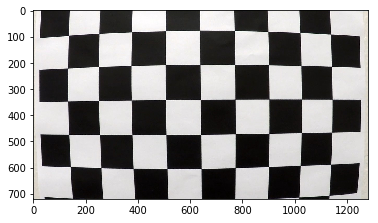

In [2]:
# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')
# Show one of the images to see the pattern. This image will not be included in the calibration
img_test = mpimg.imread(images[0])
plt.imshow(img_test)

nx = 9
ny = 6
# Create object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


In [3]:
# Step through the images list and search for chessboard corners
for idx, fname in enumerate(images[1:]):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

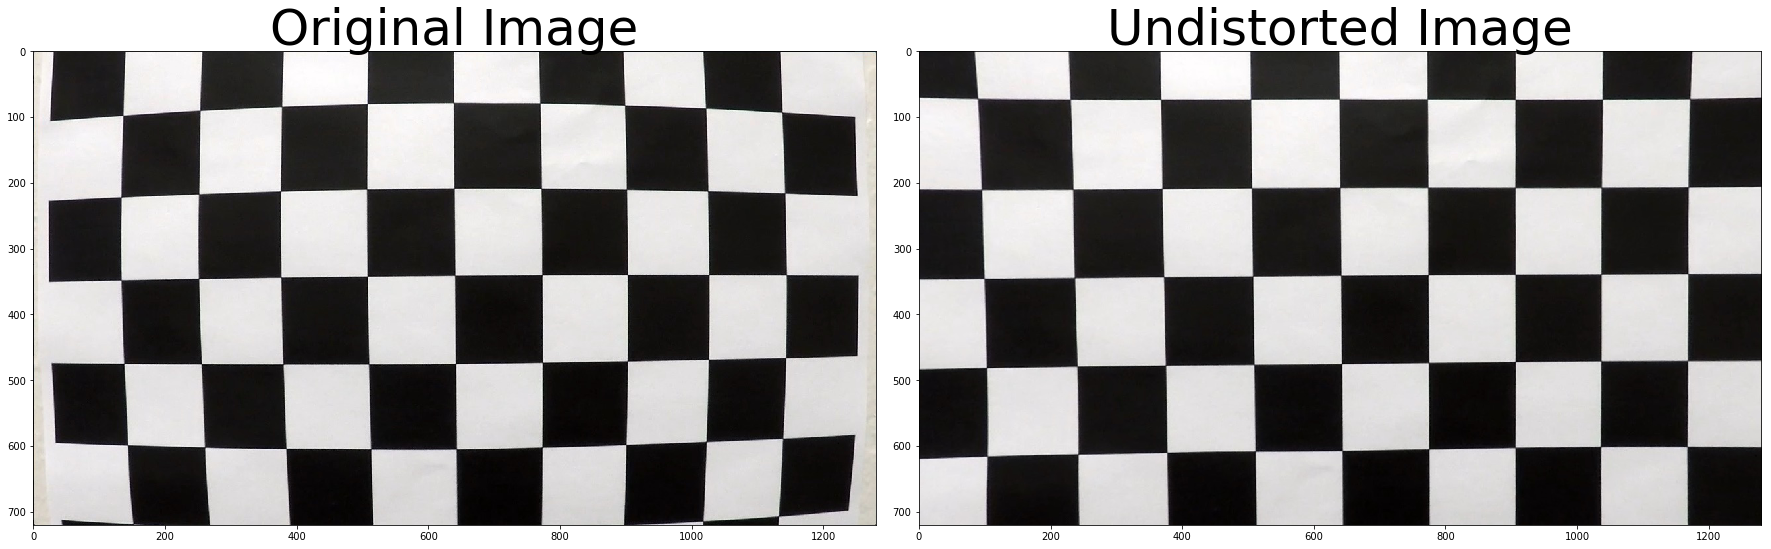

In [4]:
# Function to perform the camera calibration, image distortion correction and return the undistorted image 
def cal_undistort(img, objpoints, imgpoints):
    # Switch the order of the image dimensions
    img_size = (img.shape[1], img.shape[0])  
    # Use 'cv2.calibrateCamera' function to obtain mtx matrix and dist coefficents
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    # Use 'cv2.undistort' function to obtain the undistorted image
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst, mtx, dist

# Apply the function to the test image
undistorted, mtx, dist = cal_undistort(img_test, objpoints, imgpoints)

# Plot the image before and after applying the function
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [5]:
# Save the undistorted image
cv2.imwrite('camera_cal/undist_calibration1.jpg', undistorted)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_calibration_pickle.p", "wb" ) )

## 2. Undistort and threshold images

In this section, the lane line images are undistorted using the output from section 1, and then a combination of color and gradient thresholds are applied to obtain a binary image detecting the lane lines.


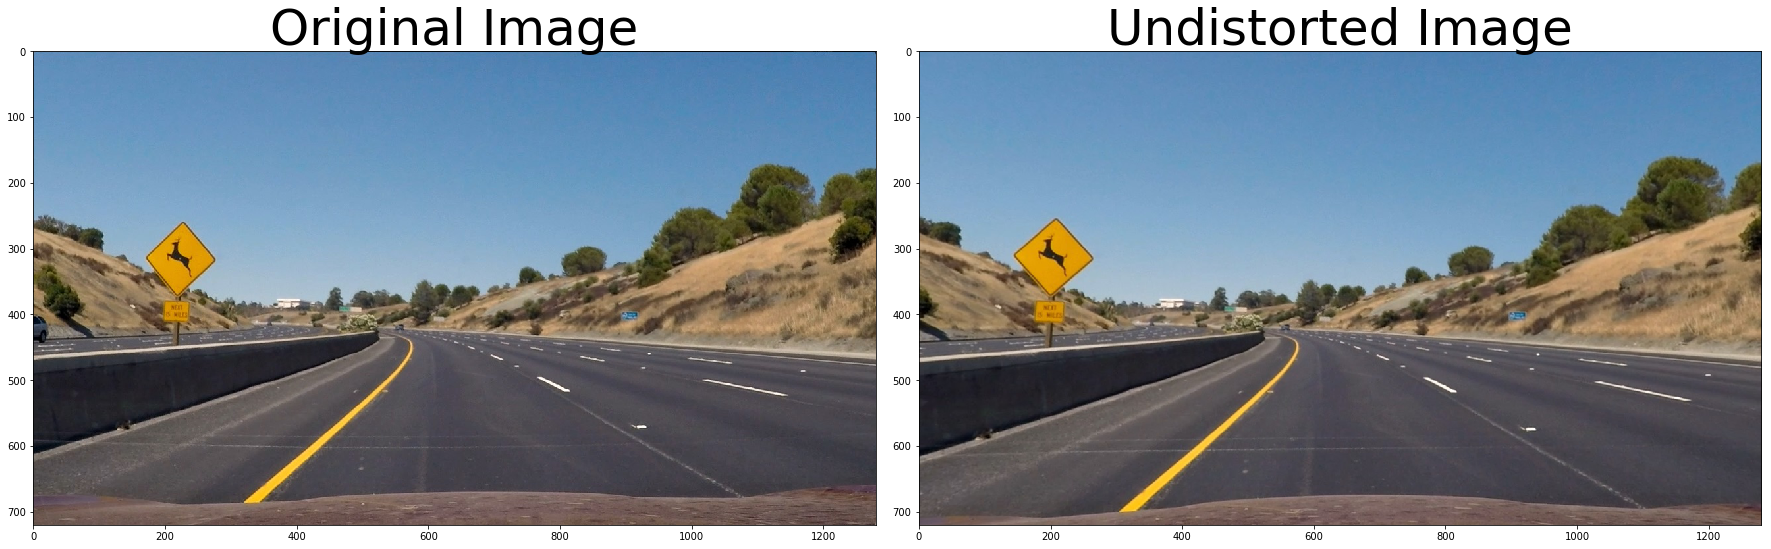

In [6]:
# Load camera parameters
with open("camera_cal/camera_calibration_pickle.p", "rb") as f:
    dist_pickle = pickle.load(f)

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Image to test the algorithms
img_test = mpimg.imread('test_images/straight_lines2.jpg')
img_test = mpimg.imread('test_images/test2.jpg')
undistorted = cv2.undistort(img_test, mtx, dist, None, mtx)

# Plot the image before and after applying the function
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### 2.1 Color thresholding

Here I transform the undistorted image to the HLS color space, since all 3 channels in this space (hue, lightness and saturation) are useful options for thresholding the image, either by color or by gradients.


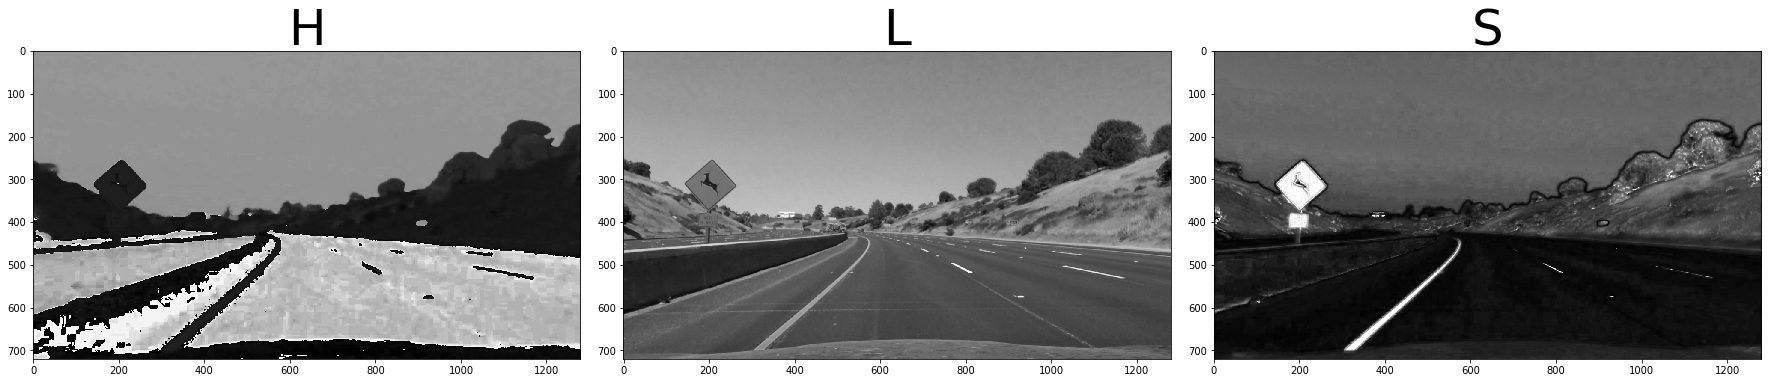

In [7]:
hls_img = cv2.cvtColor(undistorted,cv2.COLOR_RGB2HLS)

H = hls_img[:,:,0]
L = hls_img[:,:,1]
S = hls_img[:,:,2]

# Plots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H,cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(L,cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(S,cmap='gray')
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


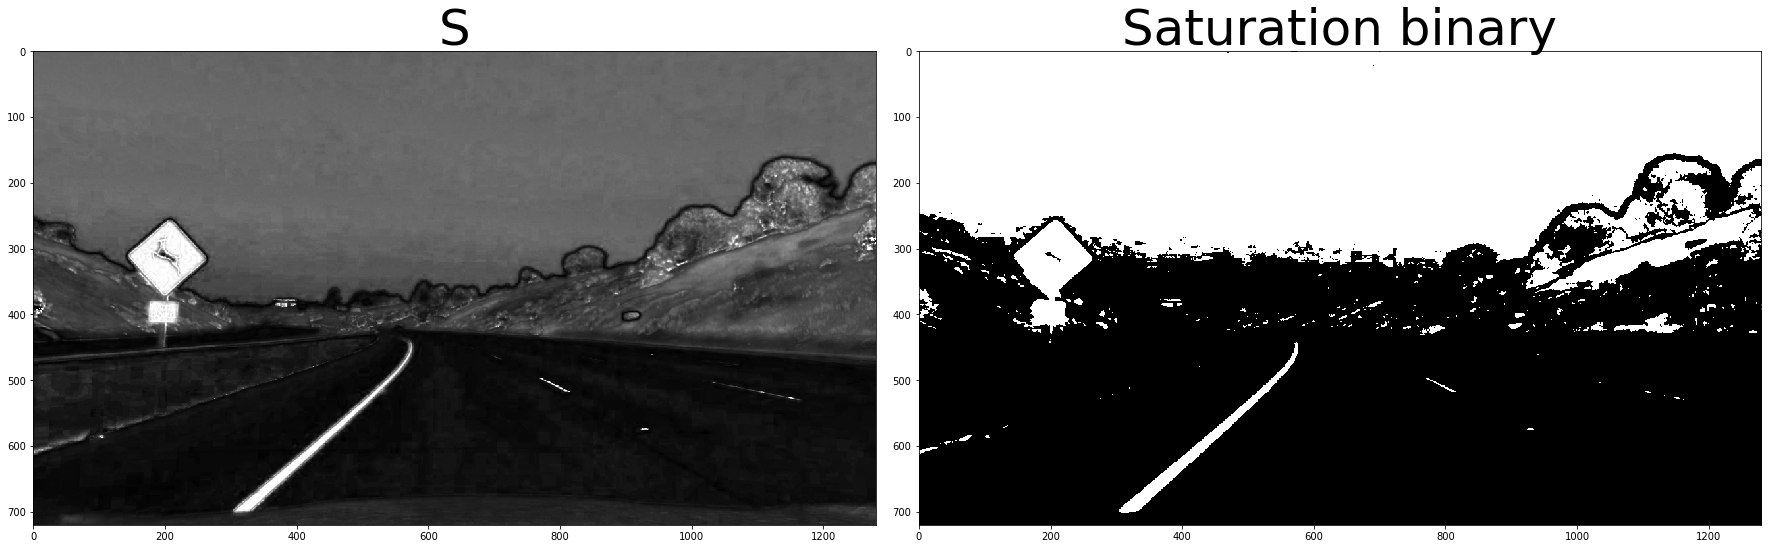

In [8]:
## Using the saturation channel to detect the lanes by color ##

# Max and Min values
sat_thresh = (90, 255)

binary_sat = np.zeros_like(S)
binary_sat[(S > sat_thresh[0]) & (S <= sat_thresh[1])] = 1

# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S,cmap='gray')
ax1.set_title('S', fontsize=50)
ax2.imshow(binary_sat, cmap='gray')
ax2.set_title('Saturation binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

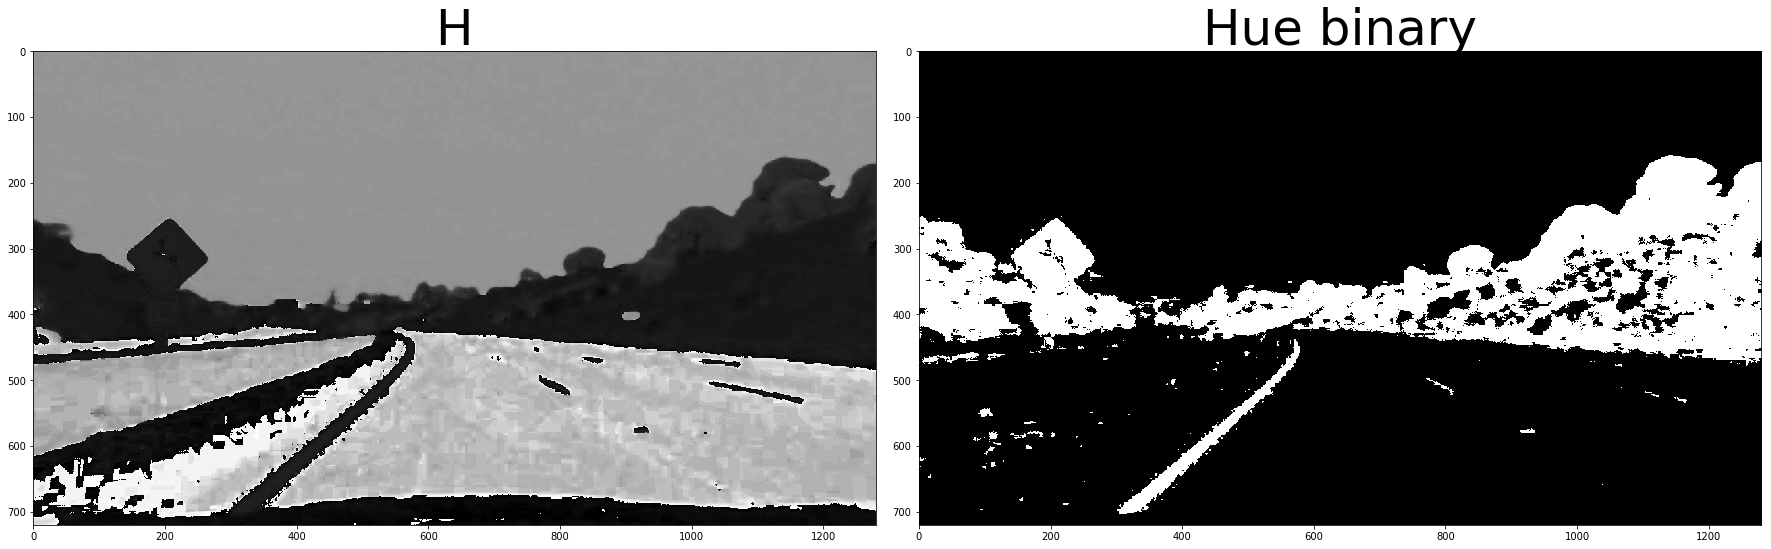

In [9]:
## Using the hue channel to detect the lanes by color ##

# Max and Min values
hue_thresh = (15, 100)

binary_hue = np.zeros_like(H)
binary_hue[(H > hue_thresh[0]) & (H <= hue_thresh[1])] = 1

# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H,cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(binary_hue, cmap='gray')
ax2.set_title('Hue binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2.2 Gradient thresholding

Since the lane lines are mostly vertical, a gradient in the x direction is considered. For this, the `cv2.Sobel` function is used.

The gradient is applied over the lightness channel, over the HLS color space. I chose this channel (over, for example the 'red' channel or the grayscale image) because it seems to give better results.


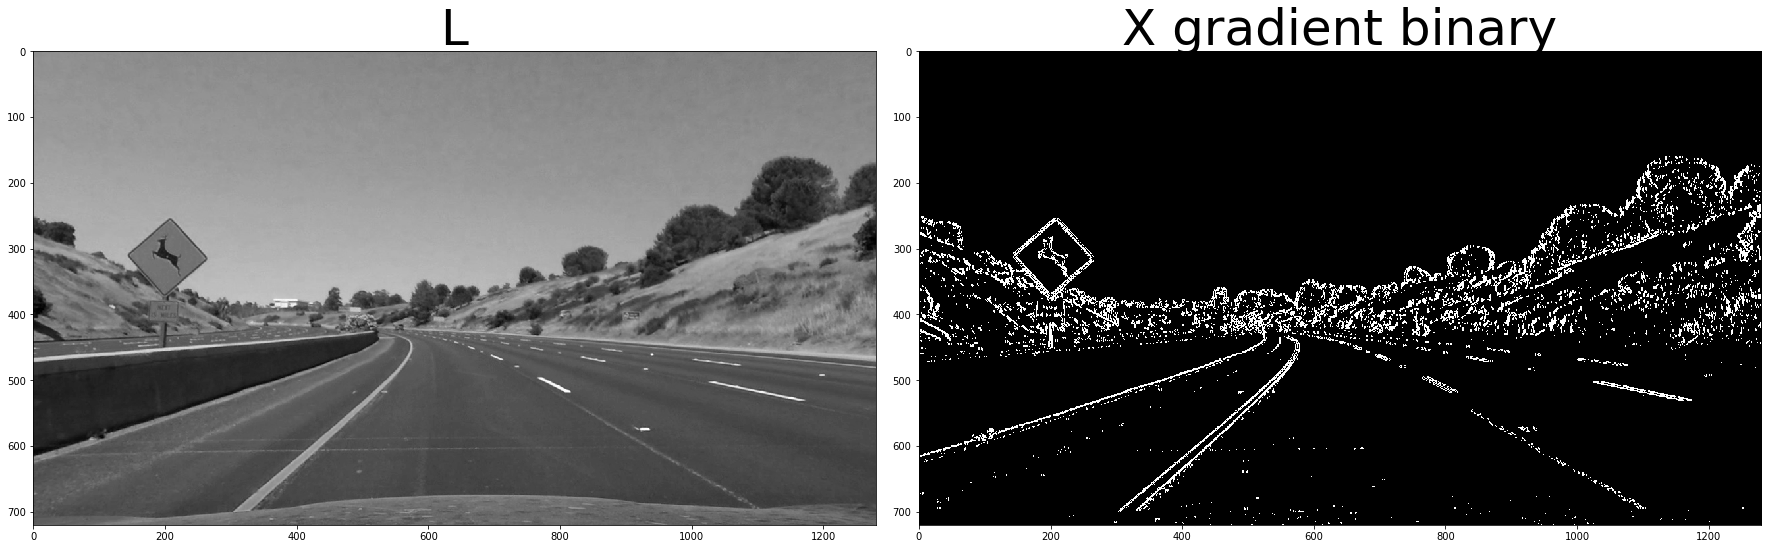

In [10]:
# Sobel x
sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.abs(sobelx) # Absolute x derivative to accentuate lines away from horizontal
# Scale the derivative to a range between 0 and 255
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
x_thresh = (20, 100)

binary_x = np.zeros_like(scaled_sobel)
binary_x[(scaled_sobel >= x_thresh[0]) & (scaled_sobel <= x_thresh[1])] = 1

# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(L,cmap='gray')
ax1.set_title('L', fontsize=50)
ax2.imshow(binary_x, cmap='gray')
ax2.set_title('X gradient binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2.3 Combination of color and gradient thresholding

In order to create a binary mask of the lines, the hue, saturation and x gradient thresholds are combined. Since there are 3 different criteria to detect if there is a line or not, I chose to make a vote, so if at least 2 of the thresholds determine that a pixel in the image contains relevant information, then this pixel is activated in the combined binary mask.


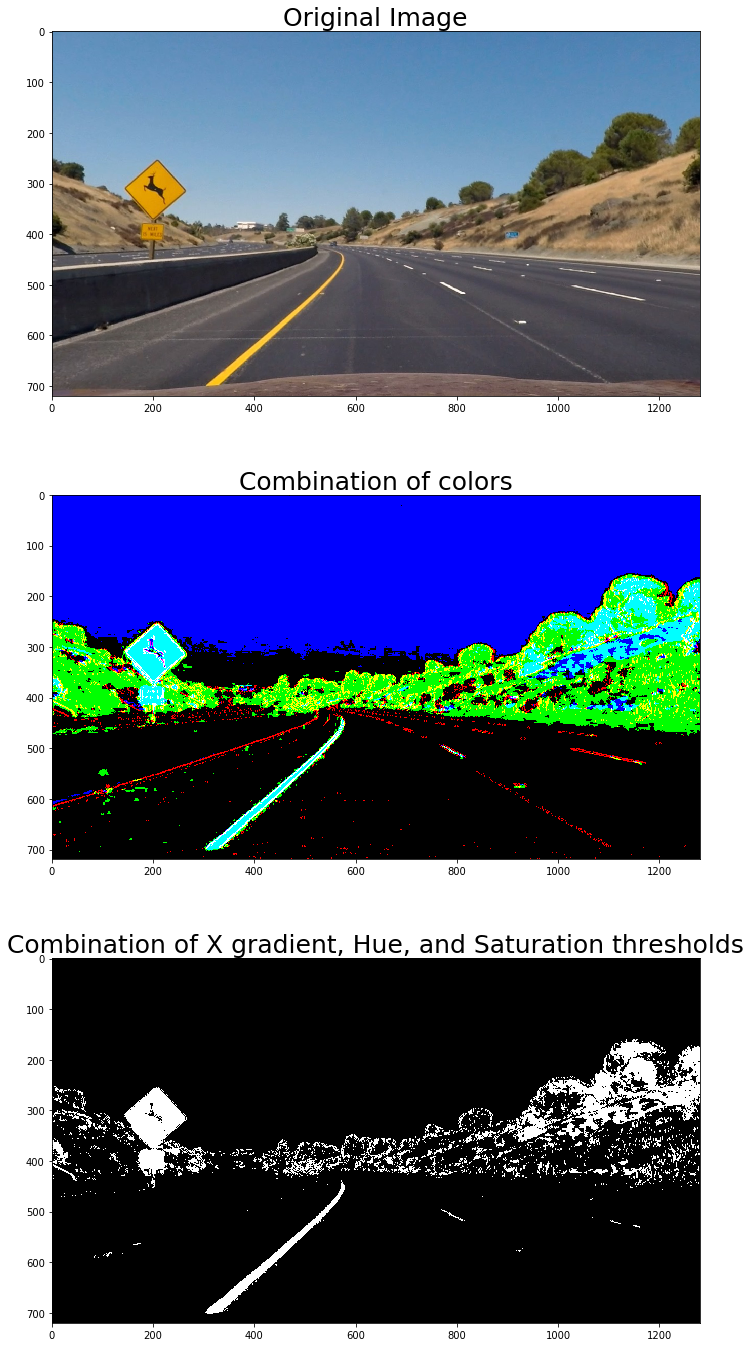

In [11]:
# Stack each channel
color_binary = np.dstack((binary_x, binary_hue, binary_sat)) * 255

combined_binary = np.zeros_like(binary_x)
combined_binary[(binary_x + binary_sat + binary_hue) > 1] = 1 # At least 2 criteria must be 1

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 21))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(color_binary)
ax2.set_title('Combination of colors', fontsize=25)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combination of X gradient, Hue, and Saturation thresholds', fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## 3. Perspective transform

After a binary image has been created with the help of color and gradient thresholds, it is necessary to perform a perspective transform, in order to obtain a top view of the region of interest.

For doing this, source and destinations image points must be defined. I used the points showed in the file *example_writeup.pdf* as a guide for this, changing the source points location just a little.


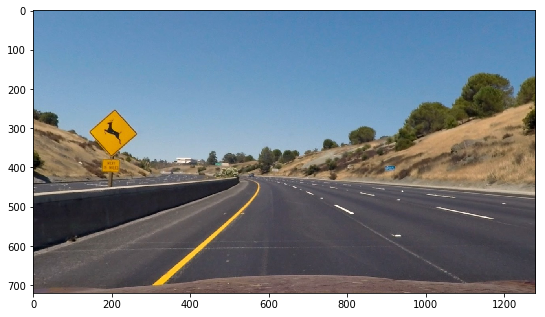

In [12]:
# Plot again the undistorted image
plt.figure(figsize=(9,7))
plt.imshow(undistorted)
plt.show()


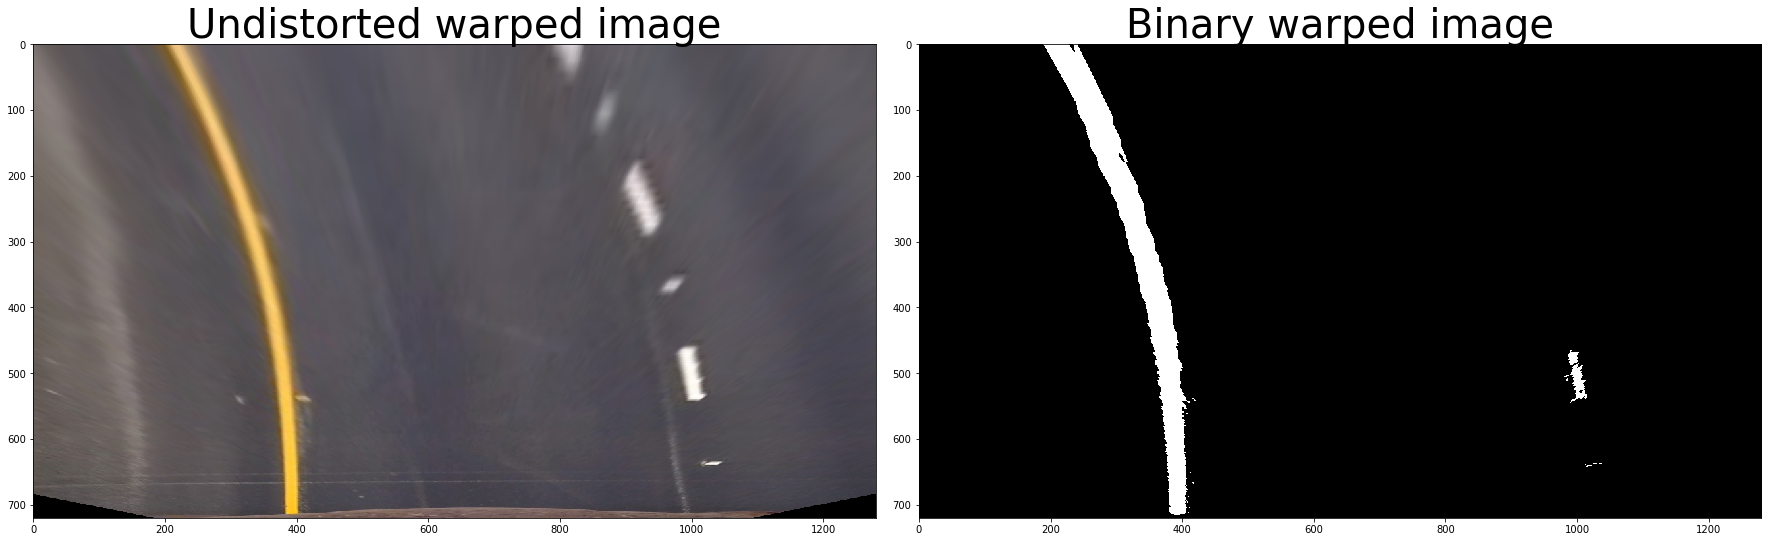

In [13]:
# Define the source and destination points, to perform the perspective transform
img_size = (undistorted.shape[1], undistorted.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 50, img_size[1] / 2 + 91],
    [((img_size[0] / 6) - 25), img_size[1]],
    [(img_size[0] * 5 / 6) + 30, img_size[1]],
    [(img_size[0] / 2 + 50), img_size[1] / 2 +91]])

dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

# Function to warp the image: Uses the cv2.warpPerspective() function to warp the image to a top-down view
def warp_image(image, src, dst):
    img_size = (image.shape[1], image.shape[0])
    # Calculate the perspective transform matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image with the perspective transform matrix
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

M, Minv, warped = warp_image(combined_binary, src, dst)

# Show the warped undistorted and binary images
# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR))
ax1.set_title('Undistorted warped image', fontsize=40)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Binary warped image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Line detection

This section deals with the problem of finding a 2nd order equation to approximate the location of both the left and right lane lines.

This task can be divided into smaller actions, shown below.


### 4.1 Define a class to receive the characteristics of each line detection

This is a suggestion given by Udacity, and it helps in keeping track of previous parameters of the lane lines. This can be really useful when the algorithm has trouble finding the lines in a specific frame or group of frames in a video/recording. 

The class is provided with several attributes and two methods, to initialize and update the lines’ parameters.


In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        ## DETECTION OF THE LINE ##
        # was the line detected in the last iteration?
        self.detected = False 
        # Number of times in a row that no line has been detected 
        self.last_non_detected = 0  
        # boolean to indicate if the line search process must be started over
        self.reset = True
        
        ## X VALUES OF THE LINE ##
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        ## FIT COEFFICIENTS OF THE LINE ##
        # polynomial coefficients of the last n fits of the line
        self.recent_fits = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        ## PHYSICAL PARAMETERS ##
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
       
    def update_line(self,update,lane_inds,coefs,curvature,dist_center,n_last,n_reset):
        # Update the "detected" status of the line
        if update == True:
            # Detection of the line #
            self.detected = True
            self.last_non_detected = 0
            self.reset = False
            # X values of the line #
            self.recent_xfitted.append(lane_inds)
            self.recent_xfitted = self.recent_xfitted[-n_last:]
            self.bestx = np.mean(np.array(self.recent_xfitted),axis=0)
#             self.bestx = np.concatenate(self.recent_xfitted).mean()
            # Fit coefficients of the line #
            self.recent_fits.append(coefs)
            self.recent_fits = self.recent_fits[-n_last:]
            self.best_fit = np.mean(np.array(self.recent_fits),axis=0)
            self.current_fit = coefs
            self.diffs =  self.current_fit - self.best_fit
            # Physical parameters #
            self.radius_of_curvature = curvature
            self.line_base_pos = dist_center
        else:
            self.detected = False
            self.last_non_detected += 1
            if self.last_non_detected >= n_reset:
                self.reset = True
        

### 4.2 Find the lines "from scratch"

Two functions are defined to detect the lines. The first function implements a histogram/sliding windows approach to detect where in the warped image are the lines located (x and y coordinates). This function receives the binary warped image and returns the list of x and y coordinates for the points that fall into both the left and right lines. 

The second function receives these lists of coordinates and fits a second-degree polynomial for each line.


In [15]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    windows_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # 2. Find the boundaries of our current window
        # Identify window boundaries in x and y (and right and left)
        win_y_bottom = binary_warped.shape[0] - window *windows_height
        win_y_top = binary_warped.shape[0] - (window + 1) *windows_height
        
        win_xleft_left = leftx_current - margin
        win_xleft_right = leftx_current + margin
        win_xright_left = rightx_current - margin
        win_xright_right = rightx_current + margin
        # 3. find out which activated pixels from nonzeroy and nonzerox above actually fall into the window
        good_left_inds  = ((nonzeroy >= win_y_top)&(nonzeroy < win_y_bottom)&(nonzerox >= win_xleft_left)&(nonzerox < win_xleft_right)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_top)&(nonzeroy < win_y_bottom)&(nonzerox >= win_xright_left)&(nonzerox < win_xright_right)).nonzero()[0]
        # 4. Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # 5. If the number of pixels found in step 3 are greater than the hyperparameter minpix, re-center the window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def full_fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        left_fit = np.array([1,1,0])
        right_fit = np.array([-1,-1,-40])

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty


### 4.3 Find the lines from prior

Since the lines don't necessarily move a lot from frame to frame, the results found in a previous frame can be used as a starting point for the next one. This is more time efficient because the algorithms look for the lines in a smaller area of the image.

Two functions are defined, very similar to the ones defined in section 4.2. The main difference is the function `search_around_poly`, which does not perform a sliding window search, but only search inside a defined margin around the lane line found on a previous frame.


In [16]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        left_fit = np.array([1,1,0])
        right_fit = np.array([1,-1,-40])
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

# Calcula dos regresiones cuadráticas y devuelve las lineas (puntos en x) ajustadas a estas regresiones
# A partir de los coeficientes encontrados para dos líneas, busca puntos en un margen alrededor de estas líneas, y vuelve a 
# calcular las nuevas líneas (regresiones)
def search_around_poly(binary_warped, left_fit, right_fit):
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_fitx = left_fit[0] * nonzeroy ** 2 + left_fit[1] * nonzeroy + left_fit[2]
    right_fitx = right_fit[0] * nonzeroy ** 2 + right_fit[1] * nonzeroy + right_fit[2]
    
    left_lane_inds = ((nonzerox >= left_fitx - margin)&(nonzerox < left_fitx + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= right_fitx - margin)&(nonzerox < right_fitx + margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty


### 4.4 Find the curvature of the lines and the distance to the center of the lane

When the polynomials for both lines have been found, two more values can be calculated: the curvature for each of the lines and the distance from the center of the car to the center of the lane.

These values need to be given in a distance metric, such as meters or miles, in order to be interpretable and useful. Taking this into account, it is necessary to include the conversion from pixels to the defined distance metric in the calculations.


In [17]:
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate R_curve (radius of curvature)
    def curvature_meters(y_eval, A, B, ym_per_pix):
        return (1 + (2 * A * y_eval * ym_per_pix + B)**2)**1.5 / np.abs(2*A)
    
    left_curverad  = curvature_meters(y_eval, left_fit[0], left_fit[1], ym_per_pix)
    right_curverad = curvature_meters(y_eval, right_fit[0], right_fit[1], ym_per_pix)

    return left_curverad, right_curverad

# Calculate the offset of the lane center from the center of the image (converted from pixels to meters) 
def calculate_offset(img_shape, left_fitx, right_fitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    dist = (img_shape[1]/2 - (left_fitx[0] + right_fitx[0])/2) * xm_per_pix
    return dist


### 4.5 Create and update the line objects

Two objects of the *Line* class are created; one for each line. Then, the polynomial for each line is calculated, a simple sanity check is performed and the *Line* objects are updated accordingly.


In [18]:
# Create line objects
left_line = Line()
right_line = Line()

# If any of the lines is in reset status, use "full_fit_polynomial". If not, use "search_around_poly"
if left_line.reset | right_line.reset:
    left_fit, right_fit, left_fitx, right_fitx, ploty = full_fit_polynomial(warped)
else:
    left_fit, right_fit, left_fitx, right_fitx, ploty = search_around_poly(warped, left_line.best_fit, right_line.best_fit)

# Calculate values in meters (curvatures and distance to center)
left_curverad, right_curverad = measure_curvature_real(ploty,left_fit, right_fit)
dist_center = calculate_offset(undistorted.shape, left_fitx, right_fitx)

######## Update the information for the lines ########

## Hyperparameters for the update ##
# Max standar deviation allowed for the distance between both lines at each frame
max_std = 50
# Number of past frames to take into account for calculations and to decide if a new sliding winddow search must be done
last_frames = 10
reset_frames = 5

# Indicates whether to update the information of the lines or not
update = True

if len(left_fitx) < undistorted.shape[0]:
    update = False
else:
# Sanity check: decide if the distance between both lines remains constant    
    lines_distance = np.abs(left_fitx - right_fitx)
    if np.std(lines_distance) > max_std:
        update = False

# Perform the information update
left_line.update_line(update=update,lane_inds=left_fitx,coefs=left_fit,curvature=left_curverad,
                      dist_center=dist_center,n_last=last_frames,n_reset=reset_frames)
right_line.update_line(update=update,lane_inds=right_fitx,coefs=right_fit,curvature=right_curverad,
                       dist_center=dist_center,n_last=last_frames,n_reset=reset_frames)
            
    

### 4.6 Graph the results

Finally, the two lines can be combined to create and plot a polygon in the undistorted image. In order to do this, it is necessary to:

1. Create a new image, *warp_zero*.
2. Create a polygon with the points from the two lines that were found, and plot it in *warp_zero*.
3. Apply the inverse perspective matrix to *warp_zero*, in order to take it to the original point of view.
4. Use the `cv2.addWeighted` function to add the *warp_zero* image to the *undistorted* image.
5. Plot the result


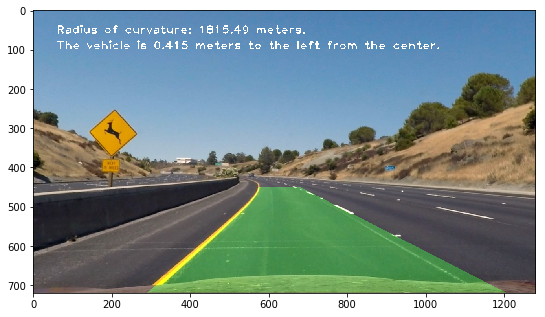

In [19]:
# This code was provided by Udacity. Thank you!

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
# Add text to the image, to inform the curvature and the distance from center
text1 = 'Radius of curvature: {0:.2f} meters.'.format(left_line.radius_of_curvature)
rel_pos = 'left' if left_line.line_base_pos > 0 else 'right'
text2 = 'The vehicle is {0:.3f} meters to the {1} from the center.'.format(left_line.line_base_pos,rel_pos)
cv2.putText(result,text1, (60,60),cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2)
cv2.putText(result,text2, (60,100),cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2)

plt.figure(figsize=(9,7))
plt.imshow(result)
plt.show()

## 5. Putting it all together

We now have all the steps necessary to find lane lines in images and videos. The last thing to do before testing it is to combine all the defined functions into a pipeline.


In [20]:
def find_lanes(image, mtx, dist, left_line, right_line):
    ## 1. Undistort image #
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    ## 2. Convert to HLS color space and create color channels #
    hls_img = cv2.cvtColor(undistorted,cv2.COLOR_RGB2HLS)
    H = hls_img[:,:,0]
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    
    ## 3. Create the 3 separate binary images #
    # Saturation
    sat_thresh = (90, 255)
    binary_sat = np.zeros_like(S)
    binary_sat[(S > sat_thresh[0]) & (S <= sat_thresh[1])] = 1
    # Hue
    hue_thresh = (15, 100)
    binary_hue = np.zeros_like(H)
    binary_hue[(H > hue_thresh[0]) & (H <= hue_thresh[1])] = 1
    # X gradient
    x_thresh = (20, 100)
    binary_x = np.zeros_like(scaled_sobel)
    binary_x[(scaled_sobel >= x_thresh[0]) & (scaled_sobel <= x_thresh[1])] = 1
    # Combined
    combined_binary = np.zeros_like(binary_x)
    combined_binary[(binary_x + binary_sat + binary_hue) > 1] = 1
    
    ## 4. Warp the combined binary image #
    # Define the source and destination points, to perform the perspective transform
    img_size = (undistorted.shape[1], undistorted.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 50, img_size[1] / 2 + 91],
        [((img_size[0] / 6) - 25), img_size[1]],
        [(img_size[0] * 5 / 6) + 30, img_size[1]],
        [(img_size[0] / 2 + 50), img_size[1] / 2 +91]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M, Minv, warped = warp_image(combined_binary, src, dst)
    
    ## 5. Find the lines # 
    if left_line.reset | right_line.reset:
        left_fit, right_fit, left_fitx, right_fitx, ploty = full_fit_polynomial(warped)
    else:
        left_fit, right_fit, left_fitx, right_fitx, ploty = search_around_poly(warped, left_line.best_fit, right_line.best_fit)
    # Calculate values in meters (curvatures and distance to center)
    left_curverad, right_curverad = measure_curvature_real(ploty,left_fit, right_fit)
    dist_center = calculate_offset(undistorted.shape, left_fitx, right_fitx)
    max_std = 50
    last_frames = 10
    reset_frames = 5
    update = True
    if len(left_fitx) < undistorted.shape[0]:
        update = False
    else:
        lines_distance = np.abs(left_fitx - right_fitx)
        if np.std(lines_distance) > max_std:
            update = False
    left_line.update_line(update=update,lane_inds=left_fitx,coefs=left_fit,curvature=left_curverad,
                          dist_center=dist_center,n_last=last_frames,n_reset=reset_frames)
    right_line.update_line(update=update,lane_inds=right_fitx,coefs=right_fit,curvature=right_curverad,
                           dist_center=dist_center,n_last=last_frames,n_reset=reset_frames)
    
    ## 6. Graph the polygon, add it to the undistorted image and return the outcome
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    try:
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    except:
        pass
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    # Add text to the image, to inform the curvature and the distance from center
    try:
        text1 = 'Radius of curvature: {0:.2f} meters.'.format(left_line.radius_of_curvature)
        rel_pos = 'left' if left_line.line_base_pos > 0 else 'right'
        text2 = 'The vehicle is {0:.3f} meters to the {1} from the center.'.format(np.abs(left_line.line_base_pos),rel_pos)
        cv2.putText(result,text1, (60,60),cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2)
        cv2.putText(result,text2, (60,100),cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2)
    except:
        pass
    
    return result

## 6. Testing the pipeline

Everything is ready now to test the pipeline in images and videos.


### 6.1 Test the pipeline in images

First, I will use the pipeline on one image. Then, all the test images will be entered to produce the output images.

In 3 of the 8 images the algorithm does not find the lines successfully. Let’s see if this can be improved in the video, with the tracking of past frames.


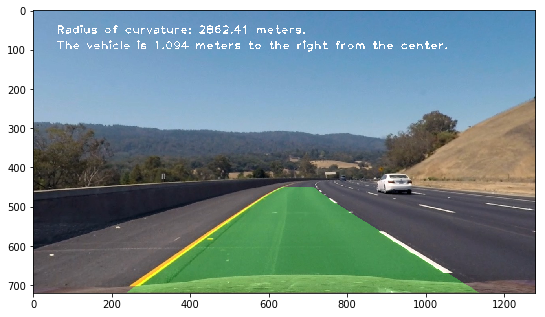

In [21]:
# Test the pipeline on an image

left_line = Line()
right_line = Line()
image = mpimg.imread('test_images/test3.jpg')
result = find_lanes(image, mtx, dist, left_line, right_line)

plt.figure(figsize=(9,7))
plt.imshow(result)
plt.show()

In [22]:
# Define the input images directory and the output directory
dir_in = "test_images/"
dir_out = "output_images/"

# Check if the output directory exists. If not, it is created
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

# Make a list of test images
images = glob.glob(dir_in + '*.jpg')

for image in images:
    left_line = Line()
    right_line = Line()
    # Read in the image
    img = mpimg.imread(image)
    # Apply the algorithm
    try:
        out_img = find_lanes(img, mtx, dist, left_line, right_line)
    except:
        out_img = img
    # Write the output image in the output path
    mpimg.imsave(dir_out + image.split(os.sep)[-1], out_img)


### 6.2 Test the pipeline in videos

First, I will use the pipeline on one video. Then, all the test videos will be entered to produce the outputs. 


In [23]:
# Define the input images directory and the output directory
dir_in = ""
dir_out = "output_videos/"

# Check if the output directory exists. If not, it is created
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

# Make a list of test videos
videos = glob.glob(dir_in + '*.mp4')

for video in videos:
    left_line = Line()
    right_line = Line()
    # Read in the video
    clip1 = VideoFileClip(video)
    # Apply the algorithm
    out_clip = clip1.fl_image(lambda image: find_lanes(image, mtx, dist, left_line, right_line))
    output = dir_out + video.split(os.sep)[-1]
    # Save the resulting video
    %time out_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:25<00:00,  6.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 28s
[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [04:23<00:00,  4.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 4min 28s
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:47<00:00,  6.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 3min 50s
